In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['r/s', 'w/s', 'kr/s', 'kw/s', 'wait', 'actv', 'wsvc_t', 'asvc_t', '%w', '%b', 'device']
TEST_CONFIG = 'max-rate-submit'
DISK_CONFIG = 'hdd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['c1t1d0', 'c1t2d0', 'c1t3d0', 'c2t0d0', 'c2t1d0', 'c2t2d0',
         'c4t0d0', 'c4t1d0', 'c4t2d0', 'c3t0d0', 'c3t1d0']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'openzfs-447-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%b', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'openzfs-447-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%b', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# OpenZFS #447 Performance Results - Fixed Rate Submit on HDDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 8 vCPUs
 - 128 GB of RAM
 - Traditional Magnetic Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

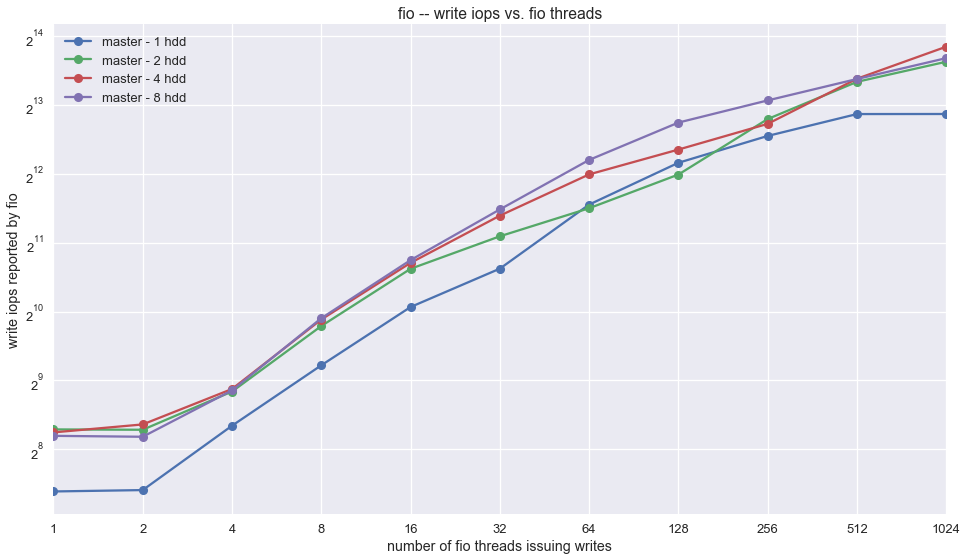

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,167.258304,312.444793,303.189894,292.878452
2,169.605066,311.354396,328.522623,290.149483
4,324.262169,457.389015,469.411902,462.847240
8,595.903879,884.861514,944.986084,957.287605
16,1071.628511,1575.023330,1672.082792,1718.954139
32,1577.105724,2184.737149,2689.662068,2863.541684
64,3007.230923,2898.521987,4075.542745,4714.240485
128,4581.062171,4069.174009,5232.947919,6867.573061
256,6002.881364,7116.632792,6780.153892,8585.032314
512,7482.713851,10350.497952,10679.182193,10650.569127


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

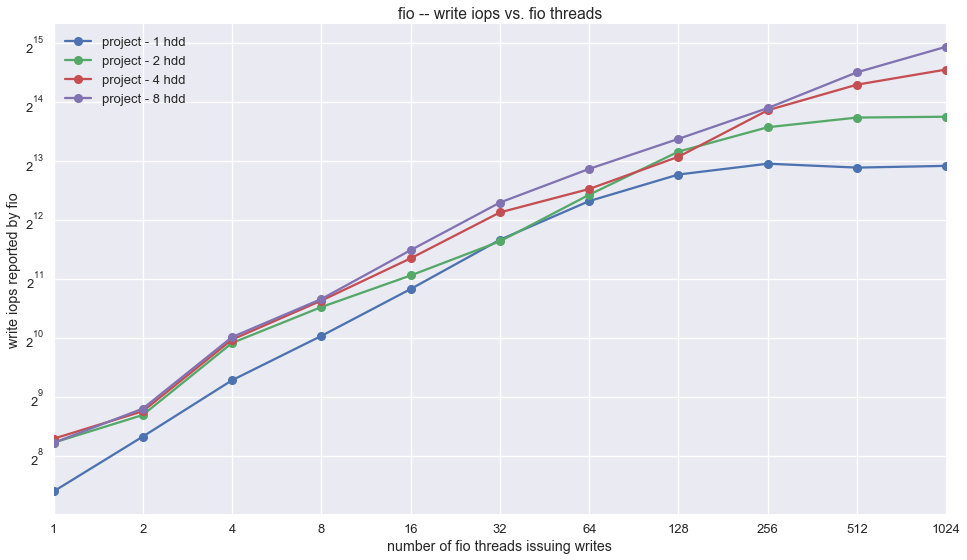

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,168.044399,298.240059,312.539582,297.720228
2,320.489959,413.196007,431.878406,445.414702
4,622.004466,964.133931,1003.516608,1033.263340
8,1047.581747,1471.084297,1587.027531,1616.742217
16,1818.574190,2132.967820,2609.702040,2874.031363
32,3247.083722,3187.612478,4480.345925,5030.096489
64,5118.437057,5514.379978,5901.498109,7477.911780
128,6996.751245,9160.785686,8625.454000,10643.808001
256,7946.224561,12204.490564,14907.493170,15287.263459
512,7590.060667,13676.253122,20140.690298,23297.673179


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

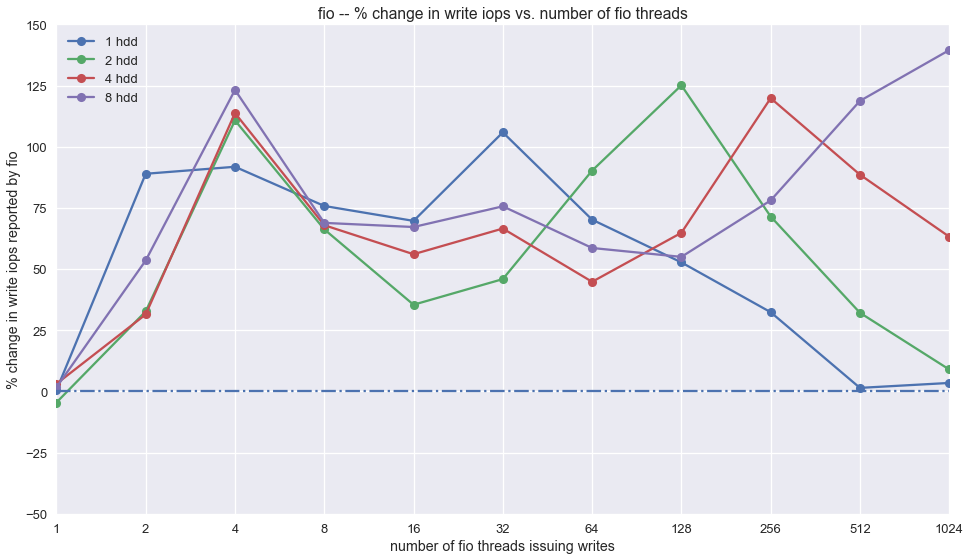

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-50, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 hdd,2 hdd,4 hdd,8 hdd
1,0.469989,-4.546318,3.083773,1.653169
2,88.962492,32.709225,31.460781,53.512147
4,91.821472,110.790793,113.781671,123.240683
8,75.797101,66.250229,67.941894,68.887825
16,69.701923,35.424522,56.074930,67.196512
32,105.888779,45.903707,66.576537,75.659971
64,70.204324,90.247995,44.802753,58.623893
128,52.732074,125.126418,64.829731,54.986455
256,32.373507,71.492487,119.869540,78.068793
512,1.434597,32.131354,88.597684,118.745805


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

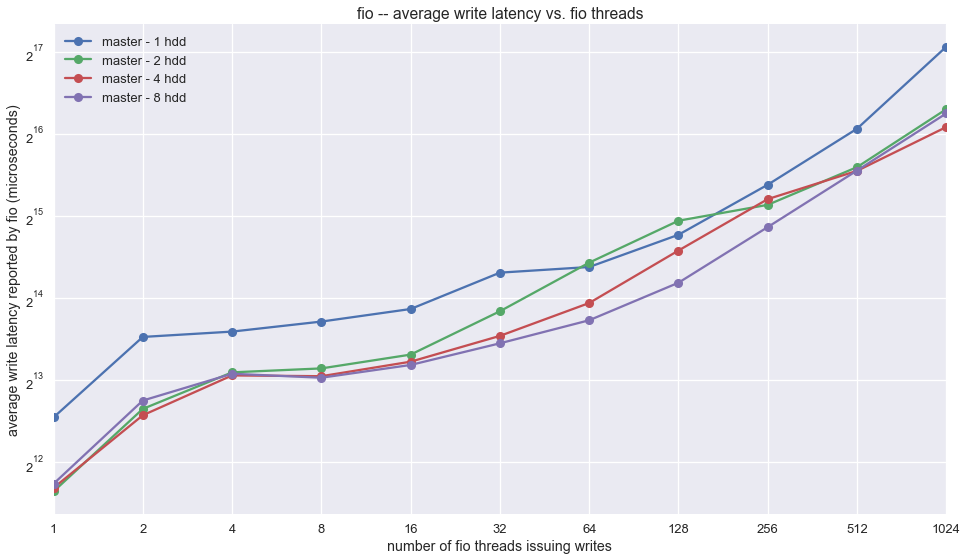

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,5976.663312,3198.492826,3296.226528,3412.314460
2,11789.357831,6421.032272,6085.522954,6890.786457
4,12332.888940,8742.707145,8518.700014,8639.739874
8,13421.788725,9038.479330,8463.593136,8354.704873
16,14925.667973,10155.958440,9566.713181,9305.790782
32,20286.160359,14644.056247,11894.353487,11172.211942
64,21275.847086,22076.274644,15698.775226,13572.805324
128,27932.791379,31446.032882,24453.434131,18633.046601
256,42626.166251,35961.598256,37742.863405,29806.150849
512,68376.515065,49438.572537,47912.933893,48040.005217


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

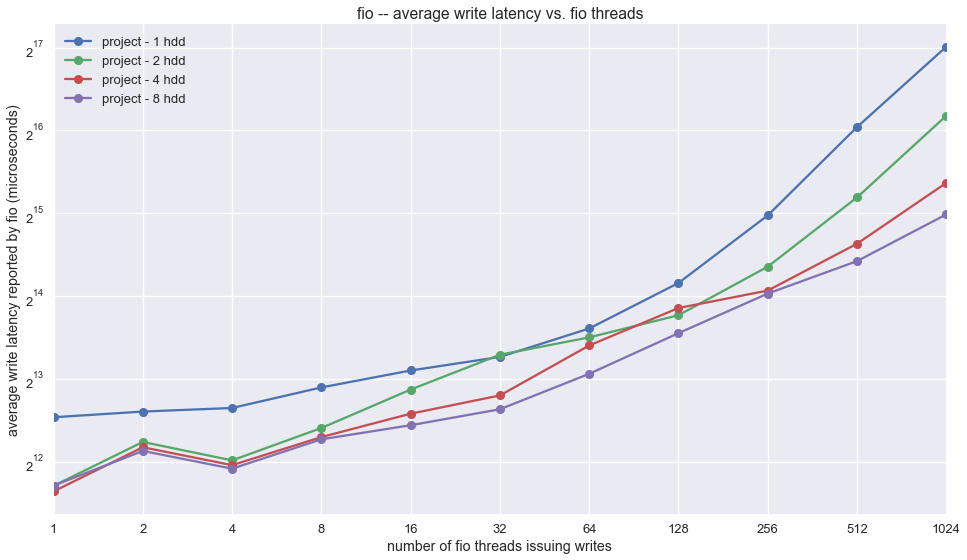

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,5948.681543,3350.991282,3197.654935,3356.819423
2,6238.409651,4838.354616,4628.916261,4488.218348
4,6428.411933,4146.935090,3984.050472,3869.255959
8,7634.506006,5436.208581,5038.845172,4946.277123
16,8795.809565,7499.166400,6128.940933,5564.965627
32,9852.344879,10036.277106,7139.452293,6359.607936
64,12500.327919,11602.787623,10842.076975,8555.021318
128,18287.927985,13967.870185,14834.544500,12021.289184
256,32194.885008,20965.551876,17166.008248,16738.910642
512,67395.895981,37413.778673,25401.581612,21963.040596


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

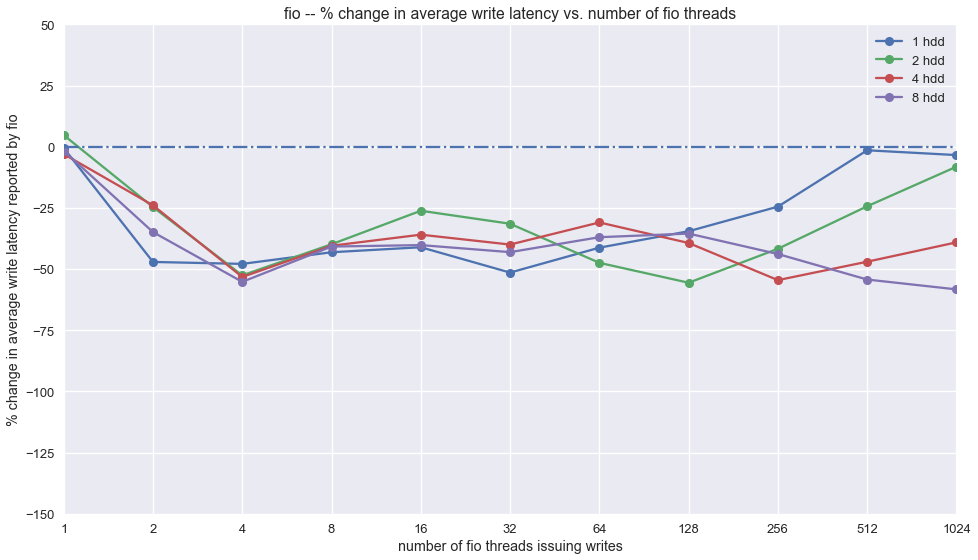

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-150, 50)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 hdd,2 hdd,4 hdd,8 hdd
1,-0.468184,4.767822,-2.990437,-1.626317
2,-47.084398,-24.648337,-23.935604,-34.866385
4,-47.875863,-52.566922,-53.231708,-55.215597
8,-43.118565,-39.854832,-40.464468,-40.796507
16,-41.069240,-26.159934,-35.934727,-40.198896
32,-51.433171,-31.465183,-39.976121,-43.076555
64,-41.246391,-47.442275,-30.936797,-36.969395
128,-34.528820,-55.581455,-39.335537,-35.484038
256,-24.471545,-41.700167,-54.518532,-43.840750
512,-1.434146,-24.322696,-46.983874,-54.281769


## `%b` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%b` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -xn 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%b` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%b` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%b` averaged across all disks in zpool vs. `fio` threads - master branch

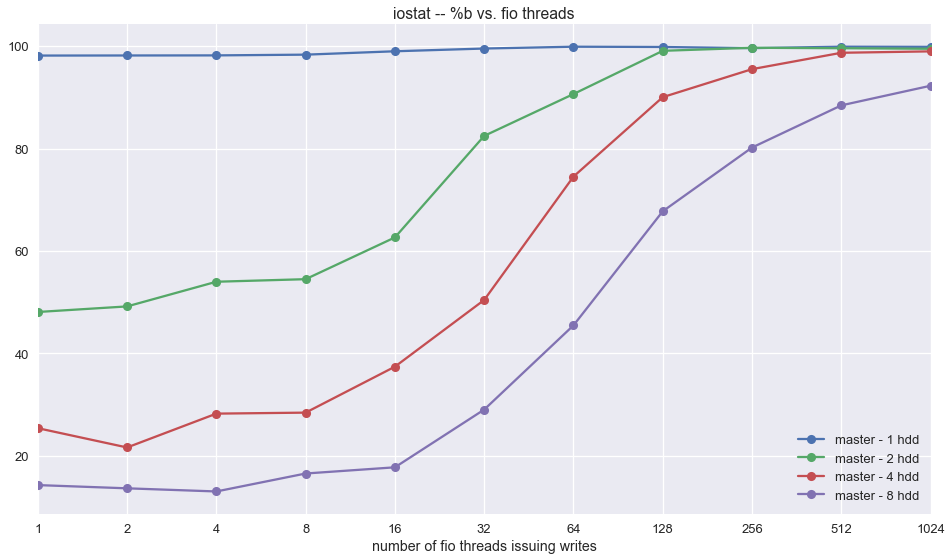

In [15]:
plot_iostat_column_dataframe(master_busy, '%b')

In [16]:
master_busy

,master - 1 hdd,master - 2 hdd,master - 4 hdd,master - 8 hdd
1,98.178571,48.071429,25.368421,14.245614
2,98.196429,49.160714,21.596491,13.614035
4,98.214286,53.982143,28.210526,13.000000
8,98.357143,54.482143,28.403509,16.508772
16,99.017857,62.642857,37.385965,17.719298
32,99.553571,82.482143,50.421053,29.000000
64,99.910714,90.660714,74.526316,45.456140
128,99.857143,99.107143,90.052632,67.754386
256,99.631579,99.701754,95.526316,80.206897
512,99.912281,99.614035,98.724138,88.448276


### `%b` averaged across all disks in zpool vs. `fio` threads - project branch

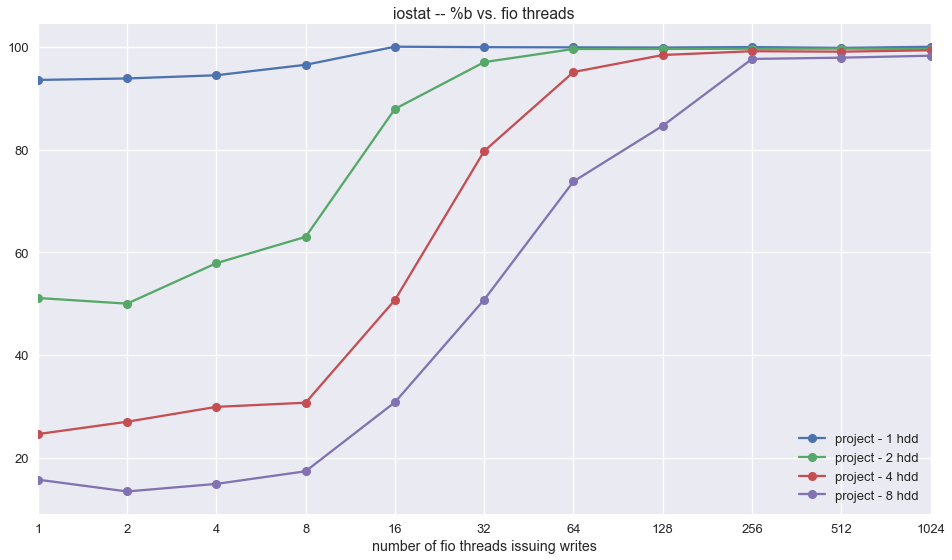

In [17]:
plot_iostat_column_dataframe(project_busy, '%b')

In [18]:
project_busy

,project - 1 hdd,project - 2 hdd,project - 4 hdd,project - 8 hdd
1,93.535714,51.125000,24.649123,15.789474
2,93.821429,50.017857,27.052632,13.491228
4,94.446429,57.892857,29.947368,14.964912
8,96.482143,63.017857,30.754386,17.421053
16,100.000000,87.892857,50.736842,30.842105
32,99.910714,97.000000,79.701754,50.789474
64,99.875000,99.553571,95.070175,73.789474
128,99.839286,99.571429,98.385965,84.620690
256,99.929825,99.596491,99.122807,97.620690
512,99.771930,99.620690,99.034483,97.864407


## on-cpu, system wide, kernel flame graphs

The visualizations below are on-cpu flame-graphs of the entire system, using kernel level stacks. Unlike the line graphs above, there isn't a straightforward way to condense all of the test runs into a single flame-graph visualization. Thus, instead of showing the unique graph for each configuration, 2 configurations were specifically chosen with hopes that these two show a representative sample of the whole population. The two chosen configurations are:

 - 1 disk zpool, with 1024 `fio` threads
 - 8 disk zpool, with 1024 `fio` threads

Both configurations have the largest number of `fio` threads available; and then one configuration has the largest number of disks, and the other configuration has the least number of disks.

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-1-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-1-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-8-hdd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-8-hdd-fio-1024-jobs-dtrace-profile.svg)